# Machine Learning

Written ny: Alessandro La Corte 100355025

## Homework #6: Hidden Markov Models for speech processing

### A. The three Basic Problems for HMMs

For convenience, we use the compact notation 

$$\lambda=(A, B,  \pi)$$

to indicate the complete parameter set of the model, where $A$ is the state transition probability distribution, $B$ the emission probability distribution (which can be any distribution with parameters $\Theta$) and $\pi$ the initial state distribution.

### Problem 1: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do efficiently compute $P(O|\lambda)$?
Problem 1 is the evaluation problem, namely given a model and a sequence of observations, how do we compute the probability that the observed sequence was produced by the model. To solve this problem we use the **forward-backward algorithm**.

### Problem 2: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do we choose a corresponding state sequence $Q= q_1, q_2, ..., q_T$?
Problem 2 is the one in which we attempt to uncover the hidden part of the model, that is, the "correct" state sequence. A formal technique for finding thes best state sequence is based on dynamic programming methods, and is called **the Viterbi algorithm**.


### Problem 3: 
How do we adjust the model parameters $\lambda=(A, B,  \pi)$ to maximize the probability of the observation sequence given the model $P(O|\lambda)$?
There is no known way to analytically solve this problem. We can, however, choose $\lambda=(A, B,  \pi)$ such that $P(O|\lambda)$? is locally maximized using an iterative procedure such as the **the Baum-Welch algoritm** (or equivalently th EM algorithm).




**Reference**

Lawrence R. Rabiner "A tutorial on hidden Markov models and selected applications in speech recognition" Proceedings of the IEEE 77.2, 1989

### B. Problem description

The aim of this session is to design a HMM-based speech recogniser.

The idea is to design a **word speech recogizer**. For each word of the 7 available words we want to fit a separate N-state HMM. We represent the speech signal of a given word as a **time sequence of coded spectral feature vectors**. For each word, we have a training sequence consisting of 15 repetitions of sequences (by one or more talkers).

* The first task is to build individual word models. **This task is done by using the solution to Problem 3** to optimally estimate model parameters for each word model.

* **To understand the physical meaning of the model states, we use the solution to Problem 2** to divide each of the word training sequences into states, and then study the properties of the spectral vectors that lead to the observation ocurring in each state.

* Finally, once the set of 7 HMMs has been fitted and optimized , **recognition of unknown word is performed using the solution of Problem 1**.

The file ``words_db.pickle`` contains 15 instances of 7 different words. ``words_db['signals']`` contains the audio signals at a sampling frequency of 8 KHz, ``words_db['features']`` contains a 6 dimensions frequency feature sequences extracted from the audio signals, and ``words_db['word_labels']`` contains the transcription of the words. 

Depending on the computer hardware specifications, the signals can be reproduced using the package ``audiolab`` from ``scikits``.

### 1. Word sequences modeling


* Load the file and select the instances of the word ``apple``
* Divide the instances of the word ``apple`` into train (5) and test (10)
* Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences
* Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.



### 2. Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.
* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.
* Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

### Solution

In [27]:
%matplotlib inline

#Load libraries
import numpy as np
import pickle
import scipy
from   hmmlearn.hmm import GaussianHMM
from   sklearn import preprocessing
from   matplotlib import pyplot as plt
from   sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut as loo

In [2]:
import warnings
warnings.simplefilter("default")

with open('words_db.pickle', 'rb') as handle:
    words_db = pickle.load(handle) 

In [3]:
# signals
signals = words_db['signals']

# features
features = words_db['features']

# words labels
labels = words_db['labels']

#print the different words
words = list(set(labels))
print(words)

['kiwi', 'apple', 'peach', 'pineapple', 'orange', 'banana', 'lime']


In [4]:
# Function that generate for a given word the training and test sets
#  from the feature sequences:

def getTrainTestSets(features,idx):
    #idx is the index vector identifying a given word 
    numsq_train=5 #the number of sequences used in the training set
    numsq_test=10 #the number of sequences used in the test set
    seqlenght_train = np.empty(numsq_train) #sequence length 
    x_train = np.empty([0,6])
    for i in range(numsq_train):
        x_train = np.append(x_train,np.transpose(features[idx[i]]),axis=0)
        seqlenght_train[i] = int(features[idx[i]].shape[1])
    #-------------------------
    seqlenght_test = np.empty(numsq_test)
    x_test = np.empty([0,6])
    for i in range(numsq_train,15):
        x_test = np.append(x_test,np.transpose(features[idx[i]]),axis=0)
        seqlenght_test[i-numsq_train] = int(features[idx[i]].shape[1])

    return x_train,seqlenght_train,x_test,seqlenght_test,

### 1. Word sequences modeling


* Load the file and select the instances of the word ``apple``
* Divide the instances of the word ``apple`` into train (5) and test (10)
* Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences
* Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.

In [5]:
#Load the file
with open('words_db.pickle', 'rb') as handle:
    words_db = pickle.load(handle) 

# signals
signals = words_db['signals']

# features
features = words_db['features']

# words labels
labels = words_db['labels']

#print the different words
words = list(set(labels))

#Select instances of the word *apple*
apple_index_vector = [i for i, j in enumerate(labels) if j == 'apple']

#Divide the instances of the word apple into train (5) and test (10)
apple_x_train, apple_seqlenght_train, apple_x_test, apple_seqlenght_test = getTrainTestSets(features, apple_index_vector)

print("Apple x train vector")
print(apple_x_train)

Apple x train vector
[[  187.5   562.5  3125.   3562.5  1625.   2375. ]
 [  875.   1625.    687.5  1187.5  1937.5  2812.5]
 [ 1000.    750.   2500.    375.    187.5  1500. ]
 ..., 
 [  500.    187.5  1062.5  1312.5  1562.5  1937.5]
 [  375.    562.5   812.5  3125.   1437.5  1812.5]
 [  750.    312.5  1500.   2062.5  3062.5  2687.5]]


In [7]:
#Train a HMM with Gaussian emission probability and 
# 3 hidden states using the train sequences and evaluate 
#  the loglikelihood on the test sequences

model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(apple_x_train, apple_seqlenght_train.astype(int))

model_score = model.score(apple_x_test, apple_seqlenght_test.astype(int))

print("The score of the HMM with 3 hidden states is ")
print(model_score)

The score of the HMM with 3 hidden states is 
-26371.4808604


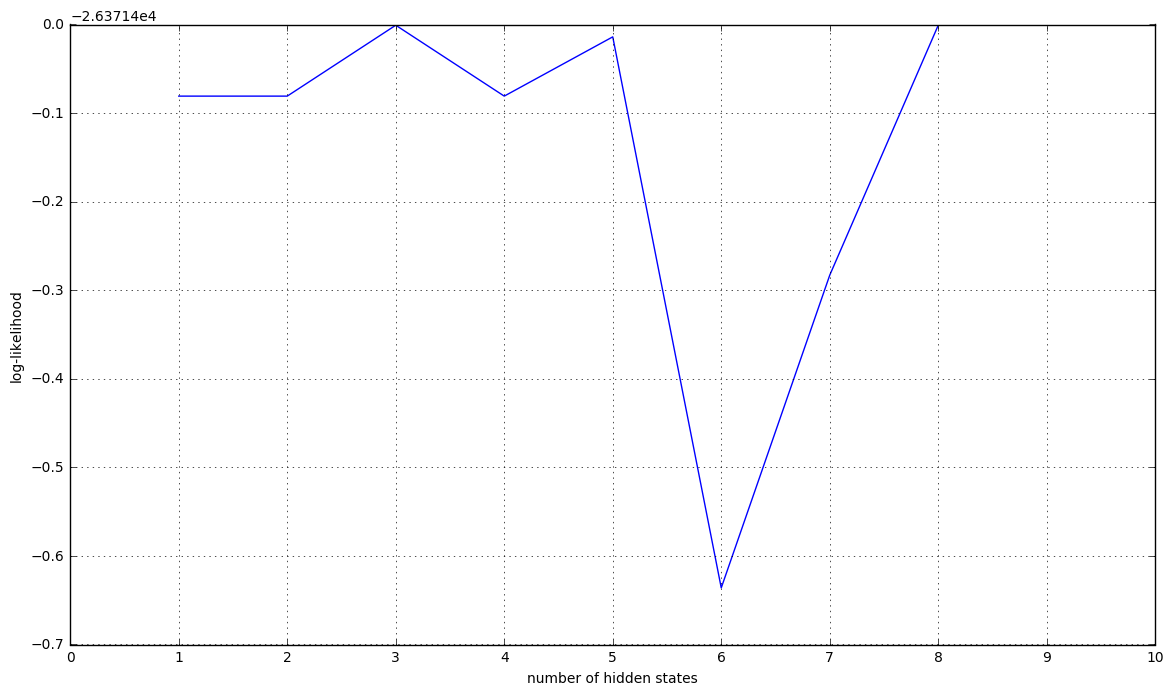

In [8]:
#Plot the loglikelihood on the test sequences using a number of 
#hidden states from 1 to 10 and comment the obtained results.

loglikelihood = []
for i in range(1,11):
    model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(apple_x_train, apple_seqlenght_train.astype(int))

    loglikelihood.append(model.score(apple_x_test, apple_seqlenght_test.astype(int)))


figure = plt.figure(figsize=(14,8), edgecolor='k', facecolor='w', dpi=80)
plt.plot(range(1,11),loglikelihood)
plt.ylabel('log-likelihood')
plt.xlabel('number of hidden states')
plt.xticks(range(0,11))
plt.grid()


It is seen that the maximum log-likelihood is achieved with 3, 5 and 8 hidden states. These hidden states perform well probably because human sounds are different at the beginning, middle and at the end. 

### 2. Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.
* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.
* Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

In [13]:
#First lets create 3 diccionaries for each word
# A diccionary for model of that word
# A diccionary for for the test set of that word
# A diccionary for the seqtest set of that word
def HMMtrainer(words):
      
    models = {}
    words_test = {}
    words_seqtest = {}
    for word in words:
        word_index = [i for i, j in enumerate(labels) if j == word]
        word_x_train, word_seqlenght_train, word_x_test, word_seqlenght_test = getTrainTestSets(features, word_index)
        words_test[word] = word_x_test
        words_seqtest[word] = word_seqlenght_test
        models[word] = GaussianHMM(n_components=3,
                                   covariance_type="diag",
                                   n_iter=1000).fit(word_x_train, word_seqlenght_train.astype(int))
        
    return models, words_test, words_seqtest



In [14]:
#Store the diccionaries

models, words_test, words_seqtest = HMMtrainer(words)

In [20]:
#Now For each word, it will be calcualted the log-likelihood of that 
# word against the model of all the set of words. 

predictions = {}

for testing_word in words:
    print('Procesing Word: ',testing_word)
    loglikelihood = {}
    for word in words:
        loglikelihood[word] = models[word].score(words_test[testing_word], words_seqtest[testing_word].astype(int))
        print('Score',word,'HMM :', loglikelihood[word])
    predictions[testing_word]= max(loglikelihood, key=loglikelihood.get)
    print('Max log-likelihood', predictions[testing_word])
    print("\n")


('Procesing Word: ', 'kiwi')
('Score', 'kiwi', 'HMM :', -26786.938354906626)
('Score', 'apple', 'HMM :', -33125.200328657957)
('Score', 'peach', 'HMM :', -27318.315026909277)
('Score', 'pineapple', 'HMM :', -34750.380269040266)
('Score', 'orange', 'HMM :', -30053.455663877052)
('Score', 'banana', 'HMM :', -44739.596365817211)
('Score', 'lime', 'HMM :', -41278.560941037591)
('Max log-likelihood', 'kiwi')


('Procesing Word: ', 'apple')
('Score', 'kiwi', 'HMM :', -34659.633141222701)
('Score', 'apple', 'HMM :', -26371.413954528522)
('Score', 'peach', 'HMM :', -31085.817588442656)
('Score', 'pineapple', 'HMM :', -26852.017081363279)
('Score', 'orange', 'HMM :', -31055.259757543557)
('Score', 'banana', 'HMM :', -27977.227228130341)
('Score', 'lime', 'HMM :', -27488.710076236726)
('Max log-likelihood', 'apple')


('Procesing Word: ', 'peach')
('Score', 'kiwi', 'HMM :', -44044.865979054055)
('Score', 'apple', 'HMM :', -61584.038250824022)
('Score', 'peach', 'HMM :', -42724.202373435197)
('Sc

In [22]:
#Get all the keys and values in a list

labels_test = list(predictions.keys())
predicted_labels = list(predictions.values())

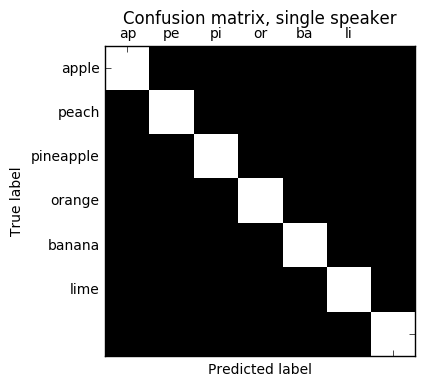

In [23]:
# Calculate and print the confusion matrix
# It is expected a diagonal matrix

cm = confusion_matrix(labels_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels(label[:2] for label in labels_test)
_ = ax.set_yticklabels(label for label in predicted_labels)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [26]:
#Leave one out

loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [28]:
def LOOcv(word):
    range_hiddenStates = range(1,11)
    LOO_lls = [] 
    for hs in range_hiddenStates:

        # Get features of a word
        word_index = [i for i, j in enumerate(labels) if j == word]
        word_features = features[word_index]

        # Find the indices for LOO
        splits = loo().split(word_features)
        

        loglikelihood_hs=[]
        
        # For each pair of train and test indices
        for looTrain_idx, looTest_idx in splits:
            
            seqlenght_train = np.empty(14) 
            x_train = np.empty([0,6])
            for i in range(0,14):
                x_train = np.append(x_train, np.transpose(word_features[looTrain_idx[i]]),axis=0)
                seqlenght_train[i] = int(word_features[looTrain_idx[i]].shape[1])
            
            x_test = np.transpose(features[looTest_idx[0]])
            seqlenght_test = [features[looTest_idx[0]].shape[1]]

            # Now, lets fit it a GaussianHMM using a train partition
            model = GaussianHMM(n_components=hs,
                                covariance_type="diag",
                                n_iter=1000).fit(x_train, seqlenght_train.astype(int))

            # Lets store the log-likelihood of the model on the test partition
            loglikelihood_hs.append(model.score(x_test, seqlenght_test))

        print('log-likelihood with ',hs,' hidden states = ',np.mean(loglikelihood_hs))
        
        # Append the average. 
        LOO_lls.append(np.mean(loglikelihood_hs))

        # The number of hidden states corresponds to the highest average loglikelihood
        
    print('The best number of hidden-states is: ', LOO_lls.index(max(LOO_lls))+1)
    return LOO_lls

In [29]:
for word in words:
    print('Lets search the best number of hidden states for the word: ',word)
    LOOcv(word)

('Lets search the best number of hidden states for the word: ', 'kiwi')
('log-likelihood with ', 1, ' hidden states = ', -2742.0953604756519)
('log-likelihood with ', 2, ' hidden states = ', -3101.739682215918)
('log-likelihood with ', 3, ' hidden states = ', -3102.050616254056)
('log-likelihood with ', 4, ' hidden states = ', -2909.553142755416)
('log-likelihood with ', 5, ' hidden states = ', -2757.9291779526361)
('log-likelihood with ', 6, ' hidden states = ', -2850.6112563898155)
('log-likelihood with ', 7, ' hidden states = ', -2903.9822231531452)
('log-likelihood with ', 8, ' hidden states = ', -2955.0618875868477)
('log-likelihood with ', 9, ' hidden states = ', -2935.0055559251323)
('log-likelihood with ', 10, ' hidden states = ', -2930.0719682430181)
('The best number of hidden-states is: ', 1)
('Lets search the best number of hidden states for the word: ', 'apple')
('log-likelihood with ', 1, ' hidden states = ', -2597.6082083159445)
('log-likelihood with ', 2, ' hidden state